In [2]:
import numpy as np
import ctypes 
import matplotlib.pyplot as plt
import networkx as nx
import time
import cvxpy as cvx
from scipy import linalg, sparse
from scipy.optimize import minimize
from numpy.ctypeslib import ndpointer
from typing import Tuple

%matplotlib inline

ModuleNotFoundError: No module named 'cvxpy'

# Моделирование квантового алгоритма QAOA и его сравнение с классическими алгоритмами

In [2]:
plt.style.use('seaborn')

## Импортируем QuEST

double MaxCut (int *arr, int numOfNodes, int numOfEdges, double* angles, int numOfAngles);

In [3]:
quest = ctypes.CDLL("./libQuEST.so")

Получаем функцию maxcut из quest, полный ее код приведен в последней ячейке

In [4]:
maxcut = quest.MaxCut

Указываем тип возвращаемого значения

In [5]:
maxcut.restype = ctypes.c_double

Задаем тип принимаемых аргументов

In [6]:
maxcut.argtypes = [ndpointer(ctypes.c_int, flags="C_CONTIGUOUS"),
                ctypes.c_int,
                ctypes.c_int,
                ndpointer(ctypes.c_double, flags="C_CONTIGUOUS"),
                ctypes.c_int]

Основная процедура программы оформлена в виде одной функции, которая принимает на вход произвольный граф и число слоев, а возвращает среднее значение гамильтониана задачи

In [7]:
def optimize(G, p):
    """
        G - исходный граф
        p - число слоев
    """
    
    # Подфункция, которая вызывает maxcut для заданного набора углов и заданного графа
    def f(angle):
        # преобразуем list в np.double, который можно подать на вход maxcut
        angles = np.array(angle, dtype=np.double)
        return -maxcut(graph_arr, len(nodes), len(edges), angles, len(angles))
    
    # Получаем все вершины графа
    nodes = sorted(tuple(G.nodes))
    
    # Получаем ребра графа
    edges = tuple(G.edges)
    
    # Записываем каждое ребро последовательно в лист
    graph_arr = []
    for i in edges:
        for j in i:
            graph_arr.append(j)
            
    # Превращаем лист в np.int32
    graph_arr = np.array(graph_arr, dtype=np.int32)
    
    # Задаем границы для оптимизационного алгоритма, а также начальное приближенпие
    bounds = []
    x0 = []
    for i in range(p):
        bounds.append((0, 2*np.pi))
        bounds.append((0, np.pi))
        # В качестве начального приближения берем произвольную точку
        x0.append(np.random.rand()*np.pi*2)
        x0.append(np.random.rand()*np.pi)
    bounds = tuple(bounds)
    
    # Наконец, вызываем оптимизационный алгоритм
    res = (minimize(f, x0, method='L-BFGS-B',
                   options={'gtol': 1e-6, 'disp': True},
                   bounds=bounds))
    
    return res

In [ ]:
def procedure(G, p):
    """
        G - исходный граф
        p - число слоев
    """
    
    # Подфункция, которая вызывает maxcut для заданного набора углов и заданного графа
    def f(angle):
        # преобразуем list в np.double, который можно подать на вход maxcut
        angles = np.array(angle, dtype=np.double)
        return -maxcut(graph_arr, len(nodes), len(edges), angles, len(angles))
    
    # Получаем все вершины графа
    nodes = sorted(tuple(G.nodes))
    
    # Получаем ребра графа
    edges = tuple(G.edges)
    
    # Записываем каждое ребро последовательно в лист
    graph_arr = []
    for i in edges:
        for j in i:
            graph_arr.append(j)
            
    # Превращаем лист в np.int32
    graph_arr = np.array(graph_arr, dtype=np.int32)
    
    # Задаем границы для оптимизационного алгоритма, а также начальное приближенпие
    bounds = []
    x0 = []
    for i in range(p):
        bounds.append((0, 2*np.pi))
        bounds.append((0, np.pi))
        # В качестве начального приближения берем произвольную точку
        x0.append(np.random.rand()*np.pi*2)
        x0.append(np.random.rand()*np.pi)
    bounds = tuple(bounds)
    
    # Наконец, вызываем оптимизационный алгоритм
    result = []
    for i in range(5):
        res = (minimize(f, x0, method='L-BFGS-B',
                   options={'gtol': 1e-6, 'disp': True},
                   bounds=bounds))
        result.append(-res.fun)
    return max(result)

### Классический алгоритм

In [8]:
def goemans_williamson(graph: nx.Graph) -> Tuple[np.ndarray, float, float]:
    """
    The Goemans-Williamson algorithm for solving the maxcut problem.

    Ref:
        Goemans, M.X. and Williamson, D.P., 1995. Improved approximation
        algorithms for maximum cut and satisfiability problems using
        semidefinite programming. Journal of the ACM (JACM), 42(6), 1115-1145
    Returns:
        np.ndarray: Graph coloring (+/-1 for each node)
        float:      The GW score for this cut.
        float:      The GW bound from the SDP relaxation
    """
    # Kudos: Originally implementation by Nick Rubin, with refactoring and
    # cleanup by Jonathon Ward and Gavin E. Crooks
    laplacian = np.array(0.25 * nx.laplacian_matrix(graph).todense())

    # Setup and solve the GW semidefinite programming problem
    psd_mat = cvx.Variable(laplacian.shape, PSD=True)
    obj = cvx.Maximize(cvx.trace(laplacian * psd_mat))
    constraints = [cvx.diag(psd_mat) == 1]  # unit norm
    prob = cvx.Problem(obj, constraints)
    prob.solve(solver=cvx.CVXOPT)

    evals, evects = np.linalg.eigh(psd_mat.value)
    sdp_vectors = evects.T[evals > float(1.0E-6)].T

    # Bound from the SDP relaxation
    bound = np.trace(laplacian @ psd_mat.value)

    random_vector = np.random.randn(sdp_vectors.shape[1])
    random_vector /= np.linalg.norm(random_vector)
    colors = np.sign([vec @ random_vector for vec in sdp_vectors])
    score = colors @ laplacian @ colors.T

    return colors, score, bound

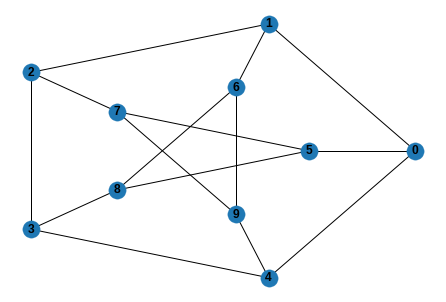

In [189]:
G = nx.petersen_graph()
nodes = sorted(tuple(G.nodes))
edges = tuple(G.edges)
nx.draw_shell(G, nlist=[range(5, 10), range(5)], with_labels=True, font_weight='bold')

In [195]:
optimize(G, 3)

      fun: -11.64889191289107
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.06581410e-06, -2.48689958e-06, -3.01980663e-06, -1.77635684e-06,
       -1.95399252e-06,  1.24344979e-06])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 273
      nit: 27
   status: 0
  success: True
        x: array([3.87799824, 2.13842908, 2.89113381, 1.31151123, 1.49434983,
       2.74170467])

In [161]:
%%time

classic_scores = []
for i in range(1000):
    partition, _, bound = goemans_williamson(G)
    classic_scores.append(_)
classic_score = np.mean(classic_scores)
result = max(classic_scores)
proba = classic_scores.count(result)/1000

CPU times: user 8min 7s, sys: 5min 36s, total: 13min 44s
Wall time: 3min 46s


# Код MaxCut

```
double MaxCut (int *arr, int numOfNodes, int numOfEdges, double* angles, int numOfAngles) {
    
    QuESTEnv env = createQuESTEnv();
    Qureg qubits = createQureg(numOfNodes, env);
    Qureg estimates = createQureg(numOfNodes, env);
    int paulis[numOfNodes*(numOfEdges+1)];
    double result;
    qreal coeffs[numOfEdges+1];

    initPlusState(qubits);
    for (int p = 0; p < numOfAngles; p+=2) {
        int temp[2];
        for (int i = 0; i < numOfEdges; i++) {
            temp[0] = *(arr+2*i);
            temp[1] = *(arr+2*i+1);
            multiRotateZ(qubits, temp, 2, angles[p]);
        }
        
        for (int i = 0; i < numOfNodes; i++) {
            rotateX(qubits, i, angles[p+1]);
        }

    }
        
    for (int i = 0; i < numOfNodes; i++) {
        paulis[i] = PAULI_I;
    }
    
    {
        int temp[numOfNodes];
        int position = numOfNodes;
        for (int i = 0; i < numOfEdges; i++) {
            for (int j = 0; j < numOfNodes; j++) {
                temp[j] = PAULI_I;
            }
            temp[*(arr+2*i)] = PAULI_Z;
            temp[*(arr+2*i+1)] = PAULI_Z;
            for (int j = 0; j < numOfNodes; j++) {
                paulis[position+j] = temp[j];
            }
            position += numOfNodes;
        }
    }
    
    coeffs[0] = (double)numOfEdges*1/2;
    for (int i = 1; i < numOfEdges+1; i++) {
        coeffs[i] = -0.5; 
    }

    result = calcExpecPauliSum(qubits, paulis, coeffs, numOfEdges+1, estimates);
    destroyQureg(qubits, env);
    destroyQureg(estimates, env);
    destroyQuESTEnv(env);
    return result;
}

```